# Classification using Meta Labelling and a Trend Following Strategy

## Part 1: Crossing Moving Avergaes as Primitive Signal Generator

This notebook develops Exercise 3.4 proposed in AFML

1. Develop a trend-following strategy (eg. crossing MAs) to get the side of each possible trade
2. Derive metalabels for an asymmetric position (2,1) and a daily vertical barrier. The target has to be the daily standard deviation.
3. Train a random forest (classifier) to decide wheater to trade or not {0,1}. Note the exogenous primary model will indeed decide the side {-1,1}

For this specific application I could not find futures data with timeframes lower than daily. We will spice it up with my lovely BTC 1h timeframe dataset spanning from 2018 to 2025. 

The dataset is continous as crypto trade 24/7 and will be of around 60k observations (manageble size).

let's DIVE IN!

In [2]:
#general purpose imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV, ParameterSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

#specific imports
sys.path.append('../scripts')
from AFML_book_scripts import *
from AFML_my_scripts import *

### Data

#### Import and Check

In [3]:
#import data
data = pd.read_csv('../data/btc_1h_data_2018_to_2025.csv')
#dataframe them
df = pd.DataFrame(data)
#keep only colums we need
df = df[['Close time', 'Open', 'High', 'Low', 'Close', 'Volume']]
#rename the columns
df = df.rename(columns={
    'Close time': 'timestamp',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})
#round the time to the nearest hour (it like 59 mminutes, 59 seconds and 999 milliseconds --> 1 hour)
# and transform the timestamp to datetime
df = df.set_index(pd.to_datetime(df['timestamp']))
# set the index to the timestamp and drop the original timestamp column
df = df.drop(columns=['timestamp'])
df.index = df.index.round('H')
df.head()

,open,high,low,close,volume
timestamp,,,,,
2018-01-01 01:00:00,13715.65,13715.65,13400.01,13529.01,443.356199
2018-01-01 02:00:00,13528.99,13595.89,13155.38,13203.06,383.697006
2018-01-01 03:00:00,13203.00,13418.43,13200.00,13330.18,429.064572
2018-01-01 04:00:00,13330.26,13611.27,13290.00,13410.03,420.087030
2018-01-01 05:00:00,13434.98,13623.29,13322.15,13601.01,340.807329


In [4]:
#before going on lets check if we have any missing values
print(f"Missing values in the dataframe: {df.isnull().sum().sum()}")
#check if we have any duplicate rows
print(f"Duplicate rows in the dataframe: {df.duplicated().sum()}")
#check the data types of the columns
print(f"Data types of the columns:\n{df.dtypes}")
#check the main statistics of the dataframe
print("Main statistics of the dataframe")
df.describe()

Missing values in the dataframe: 0
Duplicate rows in the dataframe: 0
Data types of the columns:
open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object
Main statistics of the dataframe


,open,high,low,close,volume
count,64246.000000,64246.000000,64246.000000,64246.000000,64246.000000
mean,31051.036873,31189.717382,30905.784666,31052.287485,2899.294781
std,25503.916438,25605.076599,25400.640074,25505.037132,4097.290365
min,3172.620000,3184.750000,3156.260000,3172.050000,0.000000
25%,9174.257500,9210.000000,9141.062500,9174.575000,936.093341
50%,23792.930000,23895.065000,23684.615000,23794.135000,1603.616266
75%,46636.522500,46883.825000,46346.672500,46639.797500,3061.447620
max,108320.000000,109588.000000,107780.510000,108320.010000,137207.188600


#### Statistical/Microstructure Consideration

**IMPORTANT COMMENT!!!**

Here we have two options:
1. Keep the data in this format --> time bars --> much easier to work with 
2. Transform the data into volume/dollar bars --> better statistical properties but messier to work with

So which one shall we pick?

Normally speaking volume/dollars bars are better because they have better statistical properties:
- Activity normalization (heteroskedasticity) --> grouping by vol/dol removes activity peaks and dumps 
- Greater microstrucutre information
- Less noisy for meta-labelling

This is true and stated. BUT... here we deal with cryptos... so what?

Well I expect that activity is more spread along the hours (always open market) hence this effect should be already weaker. We can verify it and eventually (if needed) also work with a logaritmic transformation.

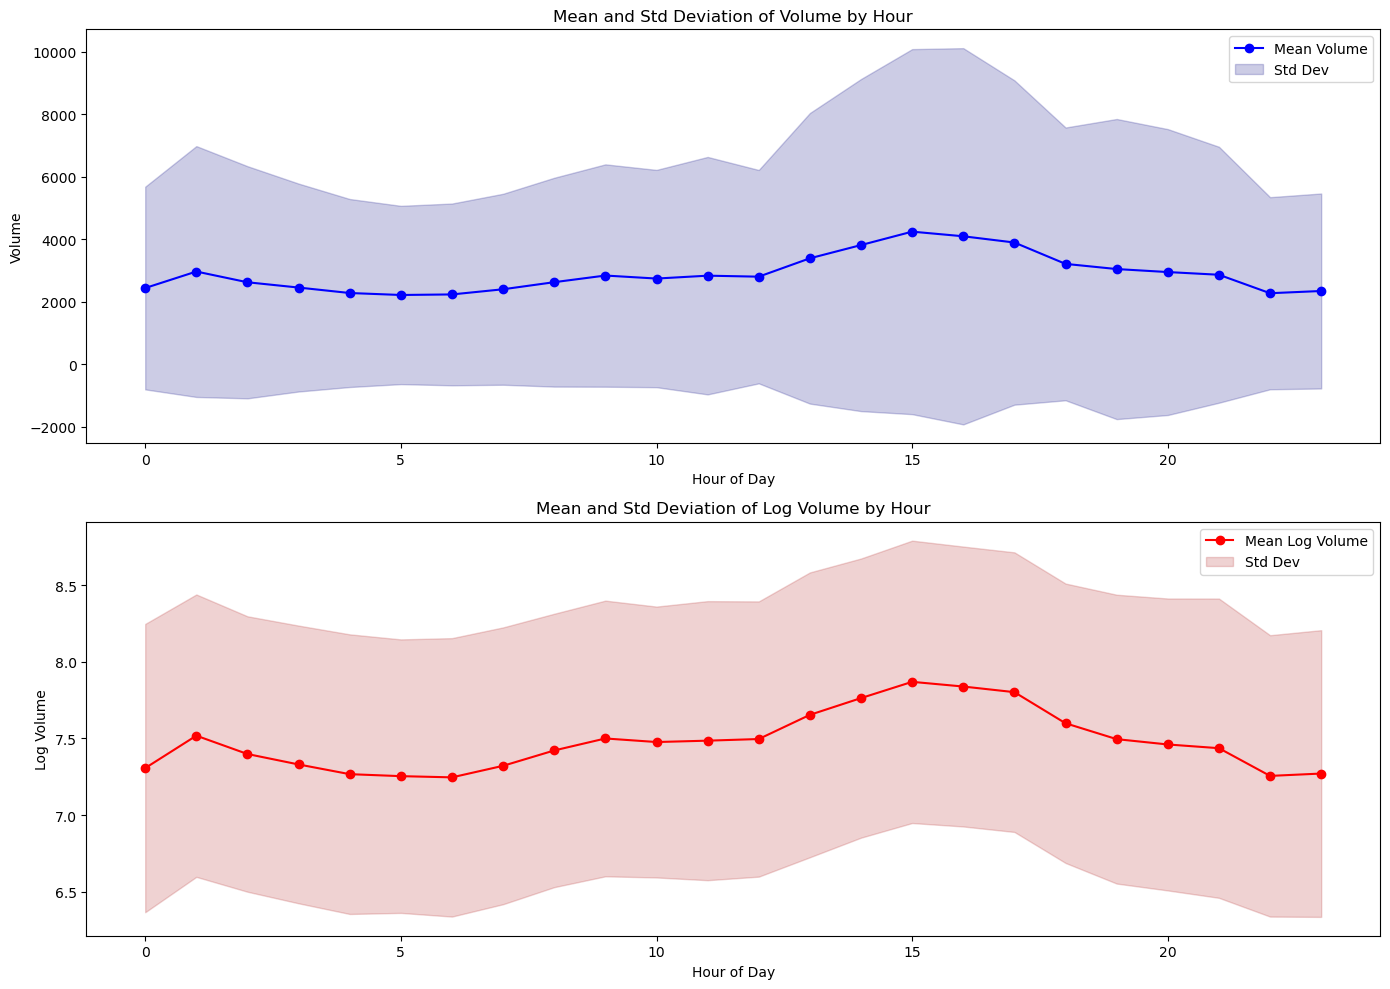

In [5]:
df['hour'] = df.index.hour
df['log_volume'] = np.log(df['volume'] + 1)  # Adding 1 to avoid log(0)
hourly_mean_volume = df.groupby('hour')['volume'].mean()
hourly_std_volume = df.groupby('hour')['volume'].std()
hourly_mean_log_volume = df.groupby('hour')['log_volume'].mean()
hourly_std_log_volume = df.groupby('hour')['log_volume'].std()

#create a grid for the plots
fig, axs = plt.subplots(2, 1, figsize=(14, 10))
# Plotting mean and std deviation of volume
axs[0].plot(hourly_mean_volume, label='Mean Volume', marker='o', color='blue')
axs[0].fill_between(hourly_mean_volume.index,
                 hourly_mean_volume - hourly_std_volume, 
                 hourly_mean_volume + hourly_std_volume, 
                 color='navy', alpha=0.2, label='Std Dev')
# Plotting mean and std deviation of log volume
axs[1].plot(hourly_mean_log_volume, label='Mean Log Volume', marker='o', color='red')
axs[1].fill_between(hourly_mean_log_volume.index,
                 hourly_mean_log_volume - hourly_std_log_volume, 
                 hourly_mean_log_volume + hourly_std_log_volume, 
                 color='firebrick', alpha=0.2, label='Std Dev')

# Setting titles and labels
axs[0].set_title('Mean and Std Deviation of Volume by Hour')    
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Volume')
axs[0].legend()
axs[1].set_title('Mean and Std Deviation of Log Volume by Hour')    
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('Log Volume')
axs[1].legend()
plt.tight_layout()
plt.show()

**RESULTS?**

I don't see a clear pattern here. Other than a peak occurring around 3pm the volume is quite steady and the log transormation is not eveually needed as the volume distribution per hour of the day is quite smooth.

--> For this analysis I consider my hypothesis quite reasonable --> we can use hourly tick data

In [6]:
#drop the columns we don't need anymore
df = df.drop(columns=['hour', 'log_volume'])
df.head()

,open,high,low,close,volume
timestamp,,,,,
2018-01-01 01:00:00,13715.65,13715.65,13400.01,13529.01,443.356199
2018-01-01 02:00:00,13528.99,13595.89,13155.38,13203.06,383.697006
2018-01-01 03:00:00,13203.00,13418.43,13200.00,13330.18,429.064572
2018-01-01 04:00:00,13330.26,13611.27,13290.00,13410.03,420.087030
2018-01-01 05:00:00,13434.98,13623.29,13322.15,13601.01,340.807329


### Crossing Moving Averages

In [7]:
#check for duplicates
print(df.index[df.index.duplicated()])
df = df[~df.index.duplicated(keep='first')]
print(df.index[df.index.duplicated()])


DatetimeIndex(['2018-01-04 03:00:00', '2018-02-08 00:00:00',
               '2018-07-04 00:00:00', '2019-06-07 21:00:00',
               '2020-03-04 09:00:00', '2021-04-25 04:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)


In [8]:
# Assuming df has a 'close' column and datetime index
fast_window = 20 # for example, 10 hours
slow_window = 200 # for example, 50 hours # 1. Compute moving averages
df['fast_ma'] = df['close'].rolling(fast_window).mean()
df['slow_ma'] = df['close'].rolling(slow_window).mean()
df['side'] = np.where(df.fast_ma > df.slow_ma, 1, -1)

In [9]:
#calculate dialy volatility
daily_vol = df['close'].pct_change().resample('D').std()
#target will have the same daily vol for each observation belonging to the same day (so we assign tot he first hour and fill up to the next day)
target = daily_vol.reindex(df.index, method = 'ffill')
# vertical barrier is 1 day, so each positioning maximum lasts 24 hours
t1 = df.index + pd.Timedelta(days=1)
t1 = t1.where(t1 < df.index[-1], pd.NaT)
t1 = pd.Series(t1, index=df.index)


#parameters to pass

minRet = 2*target.mean()
ptSl = (1,2)
tEvents = df.index
trgt = target
side = df.side
close = df.close
vert_barr = t1

In [10]:
events = getEventsMeta(close, tEvents, ptSl, trgt, minRet, t1, side)
meta_labels = getTBMLabels(events, close)

In [11]:
#check if labels are balanced
meta_labels.bin.value_counts()

bin
1.0    2977
0.0    1798
Name: count, dtype: int64

In [12]:
#curiosity check... what would be the return of the stretegy and after the meta-label check?
total_real_return = (1 + meta_labels['ret']).prod() - 1
total_bin1_return = (1 + meta_labels['ret'] * meta_labels['bin']).prod() - 1
print(f'Total real return: {total_real_return:.4f}')
print(f'Total bin1 return: {total_bin1_return:.4f}')

Total real return: 117.0490
Total bin1 return: 599356109795664911788008269745666129920.0000


### RF Classifier

Until now we did the folllwing:

1. create a simple crossing MAs strategy to position ourselves . when side is:
  - +1 enter and stay long unitl it changes to -1
  - -1 close long and open short until it changes to +1
  - repeat ...

2. We filtered some events considering them if only if the return associated with a possible trade was greater than a given threshold. We calcualted this threshold as the mean values of the daily standard deviation of returns (within a 1h timeframe OHLCV data)

3. We used the TBM to create metalabels. Those tell us if the trade we took were profitable or not by labelling them as 1 (profitable) or 0 non profitable

Now we need to train a classification method in order to predict those labels given a set of non-biased features that we have to create from the starting dataset.

We will make use of some of the following features:

| Axis                            | Example feature types                   | Intuition for bin=1 probability                             |
| ------------------------------- | --------------------------------------- | ----------------------------------------------------------- |
| **Trend strength**              | MA slope, % distance from MA, MACD      | Strong trend in same direction as `side` increases TP odds  |
| **Volatility**                  | Rolling std, ATR, Bollinger band width  | High vol may hit barriers quicker; very low vol may stall   |
| **Momentum**                    | Returns over past N bars, RSI           | Momentum aligned with side often helps win                  |
| **Mean reversion pressure**     | z-score from rolling mean, RSI extremes | Overbought/oversold may signal reversals                    |
| **Liquidity / market activity** | Rolling volume mean, volume change      | High liquidity may support trends, but also sharp reversals |
| **Recent win/loss context**     | Rolling win rate of last k trades       | “Hot/cold streak” bias capture (optional, meta-feature)     |


Once we tested we can create an feature engineering pipeline such as:

1. Compute all features on the full initial df (no filtering yet).
2. Align with meta_labels.index (keep only rows where you had an event).
3. Train-test split by time (to avoid leakage from shuffling).
4. Train RF, get importances, iterate

In [13]:
X = df.copy()
print(X.info())
X.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64240 entries, 2018-01-01 01:00:00 to 2025-05-06 00:00:00
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     64240 non-null  float64
 1   high     64240 non-null  float64
 2   low      64240 non-null  float64
 3   close    64240 non-null  float64
 4   volume   64240 non-null  float64
 5   fast_ma  64221 non-null  float64
 6   slow_ma  64041 non-null  float64
 7   side     64240 non-null  int32  
dtypes: float64(7), int32(1)
memory usage: 6.2 MB
None


,open,high,low,close,volume,fast_ma,slow_ma,side
timestamp,,,,,,,,
2018-01-01 01:00:00,13715.65,13715.65,13400.01,13529.01,443.356199,NaN,NaN,-1
2018-01-01 02:00:00,13528.99,13595.89,13155.38,13203.06,383.697006,NaN,NaN,-1
2018-01-01 03:00:00,13203.00,13418.43,13200.00,13330.18,429.064572,NaN,NaN,-1
2018-01-01 04:00:00,13330.26,13611.27,13290.00,13410.03,420.087030,NaN,NaN,-1
2018-01-01 05:00:00,13434.98,13623.29,13322.15,13601.01,340.807329,NaN,NaN,-1


In [14]:
########## Trend/Momentum features

#20 periods MA
X['ma20'] = X['close'].rolling(20).mean()
#distnace from ma20
X['ma20_dist'] = (X.close-X.ma20)/X.ma20 # Renamed to ma20_dist for clarity
#slope ma20 over k bars
k = 5
X['ma20_slope'] = X.ma20.diff(k)/k
#emas and MACD(12,26) and differences
X['ema12'] = X.close.ewm(span=12).mean()
X['ema26'] = X.close.ewm(span=26).mean()
X['macd'] = X.ema12 - X.ema26
# Calculate macd_signal and macd_diff on the X DataFrame
X['macd_signal'] = X['macd'].ewm(span=9, adjust=False).mean()
X['macd_diff'] = X['macd'] - X['macd_signal']
# past returns over some bars
X['ret1'] = X.close.pct_change(1)
X['ret5'] = X.close.pct_change(2)
X['ret20'] = X.close.pct_change(3)


############ Volatility Features

#rolling std over 20 periods
X['vol20'] = X.ret1.rolling(20).std()

#14 bars ATR
high_low = X.high - X.low
high_close = np.abs(X.high - X.close.shift())
low_close = np.abs(X.low - X.close.shift())
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
X['atr14'] = tr.rolling(14).mean()


#bollinger bands - adjusted calculation using ma20 and vol20
band_multiplier = 2 # Standard deviation multiplier for Bollinger Bands
bb_up = X.ma20 * (1 + band_multiplier * X.vol20)
bb_low = X.ma20 * (1 - band_multiplier * X.vol20)
X['bb_upper'] = bb_up # Renamed for clarity
X['bb_lower'] = bb_low # Renamed for clarity
X['bb_percent'] = (X.close - bb_low)/(bb_up - bb_low) # Position within bands (0 to 1)


########### Market Conditions Features

#RSI 14 bars
delta = X.close.diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
X['rsi14'] = 100 - (100 / (1 + rs))

#Volume deviations by z-score
X['vol_zscore'] = (X.volume - X.volume.rolling(20).mean())/X.volume.rolling(20).std()

#Corr with short term trend
ma5 = X.close.rolling(5).mean()
X['roll_corr'] = X.close.rolling(20).corr(ma5)

In [15]:
X = X.drop(['fast_ma', 'slow_ma','side','open','high','low'],axis =1)
X.head()

,close,volume,ma20,ma20_dist,ma20_slope,ema12,ema26,macd,macd_signal,macd_diff,...,ret5,ret20,vol20,atr14,bb_upper,bb_lower,bb_percent,rsi14,vol_zscore,roll_corr
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,13529.01,443.356199,NaN,NaN,NaN,13529.010000,13529.010000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,13203.06,383.697006,NaN,NaN,NaN,13352.453750,13359.766731,-7.312981,-1.462596,-5.850385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,13330.18,429.064572,NaN,NaN,NaN,13343.760300,13349.136506,-5.376205,-2.245318,-3.130887,...,-0.014697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,13410.03,420.087030,NaN,NaN,NaN,13364.679055,13366.159666,-1.480611,-2.092377,0.611766,...,0.015676,-0.008794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 05:00:00,13601.01,340.807329,NaN,NaN,NaN,13428.889328,13420.622427,8.266901,-0.020521,8.287422,...,0.020317,0.030141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### First Trainings and feature importance

In [16]:
#align the feature set with the labels

X = X.loc[meta_labels.index]
y = meta_labels['bin']

print(f'X shape: {X.shape}, y shape: {y.shape}')

X shape: (4775, 21), y shape: (4775,)


We have some Nans in X due to rolling --> we could force the vaues by mediand, bfill... but they are very little compared to the full dataset size.... checke here (we can just drop them without losing much information)


In [17]:
print(f'The percentage of missing values compared to the total number of obsertions is {round(100*X.isna().sum().max()/X.shape[0],3)}%')
obs_to_keep = ~X.isna().any(axis=1)
X = X[obs_to_keep]
y = y[obs_to_keep]
print(f'X shape: {X.shape}, y shape: {y.shape}')

The percentage of missing values compared to the total number of obsertions is 0.503%
X shape: (4751, 21), y shape: (4751,)


Using a chronological order (no shuffling) we create train and test datasets. Then the train dataset will undergo TimeSeriesSplit to form real training and validation sets!

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = False)

#visulaize where train and test datasetd end in time
print(f'X_train starts at {X_train .index[0]} and ends at {X_train.index[-1]}')
print(f'X_test starts at {X_test.index[0]} and ends at {X_test.index[-1]}')


X_train starts at 2018-01-02 01:00:00 and ends at 2021-02-24 13:00:00
X_test starts at 2021-02-24 14:00:00 and ends at 2025-04-09 23:00:00


In [ ]:
tscv = TimeSeriesSplit(n_splits=5)  # chronological splits
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=20,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced',
    max_features = 'sqrt'
)

# lists for fold metrics and fetures importances for each feature
fold_metrics = []
feature_importances = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

#train the RFC on the training sets
    clf.fit(X_tr, y_tr)
#prediction on the OOS data
    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]
#main metrics
    prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary', zero_division=0)
    auc = roc_auc_score(y_val, y_proba)
#append resutls
    fold_metrics.append({'fold': fold, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc})
    feature_importances.append(clf.feature_importances_)

In [31]:
metrics_df = pd.DataFrame(fold_metrics).set_index('fold')
mean_metrics = metrics_df.mean().to_dict()

fi_mean = np.mean(np.vstack(feature_importances), axis=0)
feat_rank = pd.Series(fi_mean, index=X.columns).sort_values(ascending=False)

print("Per-fold metrics:\n", metrics_df.round(4))

Per-fold metrics:
       precision  recall      f1     auc
fold                                   
1        0.6982  0.5960  0.6431  0.4726
2        0.6012  0.9167  0.7262  0.4920
3        0.7473  0.5574  0.6385  0.6554
4        0.5631  0.5430  0.5529  0.4350
5        0.5938  0.7103  0.6468  0.5071


In [32]:
print("\nAverage metrics:", {k: round(v, 4) for k, v in mean_metrics.items()})


Average metrics: {'precision': 0.6407, 'recall': 0.6647, 'f1': 0.6415, 'auc': 0.5124}


In [33]:
print("\nTop features:\n", feat_rank.round(4))


Top features:
 atr14          0.1006
close          0.0736
bb_lower       0.0695
ema12          0.0694
vol20          0.0691
bb_upper       0.0653
ma20           0.0631
macd_signal    0.0608
ema26          0.0592
macd_diff      0.0523
volume         0.0480
macd           0.0422
ma20_dist      0.0345
ma20_slope     0.0333
roll_corr      0.0306
bb_percent     0.0253
rsi14          0.0239
vol_zscore     0.0228
ret5           0.0204
ret1           0.0193
ret20          0.0167
dtype: float64


Let's comment these results...

**PRECISION/RECALL**

Those metrics are calculated based on a 50% chance threshold, that is they reply to:

Precision → Of all trades I entered, what % were winners?
- High precision means few false positive (we rarely enter losing trades)
- But we might miss a lot of good ones if recall is low

Recall → Of all the profitable trades, what % did I actually take?
- High recall means we do not miss many winning trades
- But we might take a lot of losses if precision is low

There is a limitation tho... if we change the threshold (say, only take trades with 70%+ predicted win probability), these metrics will change a lot — so their meaning depends on that cutoff.


**ROC/AUC**

Looks at all possible thresholds at once and measure:

*How well can my model rank good trades above bad trades?*

AUC = 0.5 → as good as random.

AUC > 0.5 → better than random ranking; the higher, the better.

Doesn’t tell us exactly how many trades will win at a given threshold but just whether the ranking is consistently correct.


*Why this matters in trading?*

If we trade every signal → precision, recall, and F1 at that threshold matter more.

If we filter and only take top-probability trades → AUC is more important, because it reflects the quality of your ranking system regardless of cutoff.

It’s like:

Precision/Recall = evaluating average results after picking a specific strike zone.

AUC = checking how good we are at ranking pitches from easiest to hardest, no matter where we draw the strike zone.

#### Hyperparameter Tuning

In [34]:
import time

param_grid = {
    'n_estimators': [20, 50, 100, 400, 800],
    'max_depth': [None, 10, 15, 20],
    'min_samples_leaf': [5, 10, 20, 30],
    'max_features': ['sqrt', 'log2', 0.5],
    'class_weight': ['balanced', 'balanced_subsample']
}

n_iter = 10  # number of random combinations to try
tscv = TimeSeriesSplit(n_splits=5)

# generate random samples
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

for i, params in enumerate(param_list, 1):
    print(f"\n=== Running iteration {i}/{n_iter} with params: {params} ===")
    clf.set_params(**params)

    fold_metrics = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_train), 1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

        clf.fit(X_tr, y_tr)
        y_proba = clf.predict_proba(X_val)[:, 1]
        y_pred = clf.predict(X_val)

        prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary', zero_division=0)
        auc = roc_auc_score(y_val, y_proba)

        fold_metrics.append({'fold': fold, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc})
        print(f"  Fold {fold} done. F1: {f1:.4f}, AUC: {auc:.4f}")

    # aggregate metrics for this iteration
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean().to_dict()
    print(f"Iteration {i} mean metrics: F1={mean_metrics['f1']:.4f}, AUC={mean_metrics['auc']:.4f}")



=== Running iteration 1/10 with params: {'n_estimators': 400, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'balanced'} ===
  Fold 1 done. F1: 0.6376, AUC: 0.5096
  Fold 2 done. F1: 0.7290, AUC: 0.5025
  Fold 3 done. F1: 0.6910, AUC: 0.6645
  Fold 4 done. F1: 0.5814, AUC: 0.4156
  Fold 5 done. F1: 0.6685, AUC: 0.5250
Iteration 1 mean metrics: F1=0.6615, AUC=0.5234

=== Running iteration 2/10 with params: {'n_estimators': 800, 'min_samples_leaf': 20, 'max_features': 0.5, 'max_depth': 15, 'class_weight': 'balanced_subsample'} ===
  Fold 1 done. F1: 0.6134, AUC: 0.4974
  Fold 2 done. F1: 0.7399, AUC: 0.5060
  Fold 3 done. F1: 0.7109, AUC: 0.6511
  Fold 4 done. F1: 0.5856, AUC: 0.4125
  Fold 5 done. F1: 0.6237, AUC: 0.5348
Iteration 2 mean metrics: F1=0.6547, AUC=0.5204

=== Running iteration 3/10 with params: {'n_estimators': 800, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': 15, 'class_weight': 'balanced_subsample'} ===
  Fold 1 done. F1

The random test of different hyperparameters combination did not improve the situation, the model itself or the singal generated are not very good to obtain great results... 

Several reason might influence this results... most of them are explained here:

https://github.com/dgalassi99/quant-lab/blob/main/book_projects/Advances_Financial_Machine_Learning/notebooks/Sampling%20Weights/theory.md

## Mean Reverting Strategy With Bollinger Bands as Primitive Signal Generator

From EXERCISE 3.5

Develop a mean-reverting strategy based on Bollinger bands. For each observa-
tion, the model suggests a side, but not a size of the bet.

1. Derive meta-labels for ptSl=[0,2] and t1 where numDays=1. Use as
trgt the daily standard deviation as computed by Snippet 3.1.

2. Train a random forest to decide whether to trade or not. Use as fea-
tures: volatility, serial correlation, and the crossing moving averages from past exercises

3. What is the accuracy of predictions from the primary model (i.e., if the sec-
ondary model does not filter the bets)? What are the precision, recall, and F1-scores?

4. What is the accuracy of predictions from the secondary model? What are the
precision, recall, and F1-scores?

ALERT!!!

THIS STRATEGY IS A SUICIDE FOR ASSETS SUCH AS BITCOIN DUE TO THE VERY STRONG UPTREND... BUT WE ARE HERE FOR LEARNING NOT TO MAKE MONEY, YET.

In [48]:
#extra libraries for model evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [36]:
#we use the same data as part one...
df = pd.DataFrame(data)
df = df.rename(columns={'Close time': 'datetime', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
df = df.drop(columns=['Open time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'],axis=1)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime') # Now set the index using the column name
df.index = df.index.round('H')

In [37]:
print(df.index[df.index.duplicated()])
df = df[~df.index.duplicated(keep='first')]
print(df.index[df.index.duplicated()])

DatetimeIndex(['2018-01-04 03:00:00', '2018-02-08 00:00:00',
               '2018-07-04 00:00:00', '2019-06-07 21:00:00',
               '2020-03-04 09:00:00', '2021-04-25 04:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', name='datetime', freq=None)


### Bollinger Bands Mean Reverting Primary Signal

In [38]:
# window lookbar and std multiplier
window = 20
k = 2

#ma, std and upper/lower bb bands
df['ma'] = df['close'].rolling(window).mean()
df['std'] = df['close'].rolling(window).std()
df['upper_band'] = df['ma'] + k * df['std']
df['lower_band'] = df['ma'] - k * df['std']

#stretegy

#long if price goes below lower bb
#short if price goes above upper bb
# no position id between bands

df['side'] = 0
df.loc[df.close < df.lower_band, 'side'] = 1
df.loc[df.close > df.upper_band, 'side'] = -1

In [ ]:
#calculate dialy volatility
daily_vol = df['close'].pct_change().resample('D').std()
#target will have the same daily vol for each observation belonging to the same day (so we assign tot he first hour and fill up to the next day)
target = daily_vol.reindex(df.index, method = 'ffill')
# vertical barrier is 1 day, so each positioning maximum lasts 24 hours
t1 = df.index + pd.Timedelta(days=1)
t1 = t1.where(t1 < df.index[-1], pd.NaT)
t1 = pd.Series(t1, index=df.index)


#parameters to pass

minRet = target.mean()
ptSl = (0,2)
tEvents = df.index
trgt = target
side = df.side
close = df.close
vert_barr = t1

In [40]:
events = getEventsMeta(close, tEvents, ptSl, trgt, minRet, t1, side)
meta_labels = getTBMLabels(events, close)

In [41]:
#check if labels are balanced
print(meta_labels.bin.value_counts())

bin
0.0    22358
1.0     1232
Name: count, dtype: int64


### Feature Creation and RF Classifier

In [42]:
#calculate hourly returns
df['returns'] = df['close'].pct_change()
#volatility
df['volatility'] = df['close'].rolling(window=20).std()  # same window as BB
#serial correlation
df['return'] = df['close'].pct_change()  # daily returns
df['serial_corr'] = df['close'].rolling(window=20).apply(lambda x: x.autocorr(lag=1), raw=False)
#crossing moving averages
short_window = 7
long_window = 20

df['MA_short'] = df['close'].rolling(short_window).mean()
df['MA_long'] = df['close'].rolling(long_window).mean()

# Crossing feature: 1 if short MA above long MA, -1 if below, 0 if equal
df['ma_cross'] = 0
df.loc[df['MA_short'] > df['MA_long'], 'ma_cross'] = 1
df.loc[df['MA_short'] < df['MA_long'], 'ma_cross'] = -1


In [43]:
features = ['volatility', 'serial_corr', 'ma_cross']
X = df[features]
print(X.shape)

#align the feature set with the labels and drop NANs

X = X.loc[meta_labels.index]
print(X.shape)
X = X.dropna()
print(X.shape)

y = meta_labels['bin']
print(y.shape)
y = y.loc[X.index]
print(f'X shape: {X.shape}, y shape: {y.shape}')

(64240, 3)
(23590, 3)
(23571, 3)
(23590,)
X shape: (23571, 3), y shape: (23571,)


In [45]:
# Train-test split (80-20) - Not shuffled!!!
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_leaf=10, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, random_state=42)

In [46]:
#predictions on the meta_labels
y_rf_pred = rf.predict(X_test)

#predictions on the primary model (if side != 0 we are trading)
y_primary_pred = np.where(df.loc[y_test.index, 'side'] != 0, 1, 0)

In [49]:
# --------------------------
# Evaluate primary model
# --------------------------
acc_primary = accuracy_score(y_test, y_primary_pred)
prec_primary = precision_score(y_test, y_primary_pred)
rec_primary = recall_score(y_test, y_primary_pred)
f1_primary = f1_score(y_test, y_primary_pred)

print("Primary Model Metrics:")
print(f"Accuracy: {acc_primary:.3f}, Precision: {prec_primary:.3f}, Recall: {rec_primary:.3f}, F1-score: {f1_primary:.3f}")

# --------------------------
# Evaluate secondary model (RF)
# --------------------------
acc_rf = accuracy_score(y_test, y_rf_pred)
prec_rf = precision_score(y_test, y_rf_pred)
rec_rf = recall_score(y_test, y_rf_pred)
f1_rf = f1_score(y_test, y_rf_pred)

print("\nSecondary Model (RF) Metrics:")
print(f"Accuracy: {acc_rf:.3f}, Precision: {prec_rf:.3f}, Recall: {rec_rf:.3f}, F1-score: {f1_rf:.3f}")

Primary Model Metrics:
Accuracy: 0.910, Precision: 0.409, Recall: 1.000, F1-score: 0.581

Secondary Model (RF) Metrics:
Accuracy: 0.793, Precision: 0.061, Recall: 0.160, F1-score: 0.088


In [ ]:
###PRIMARY MODEL###

#create primary model signals: 1 if trade, 0 if no trade, with direction from signal (+1/-1)
primary_signal = df.loc[y_test.index, 'side']  # +1/-1/0
primary_signal = primary_signal.fillna(0)
#align with actual returns (assuming you have a column 'returns' in df)
returns = df.loc[y_test.index, 'returns'].fillna(0)
#Primary model strategy returns
primary_ret = primary_signal * returns
#Cumulative returns
primary_cumret = (1 + primary_ret).cumprod()

##META-LABELLED MODEL###

# RF predictions: 1 = trade, 0 = skip
secondary_filter = y_rf_pred  # from RF
filtered_signal = primary_signal * secondary_filter
secondary_ret = filtered_signal * returns
secondary_cumret = (1 + secondary_ret).cumprod()

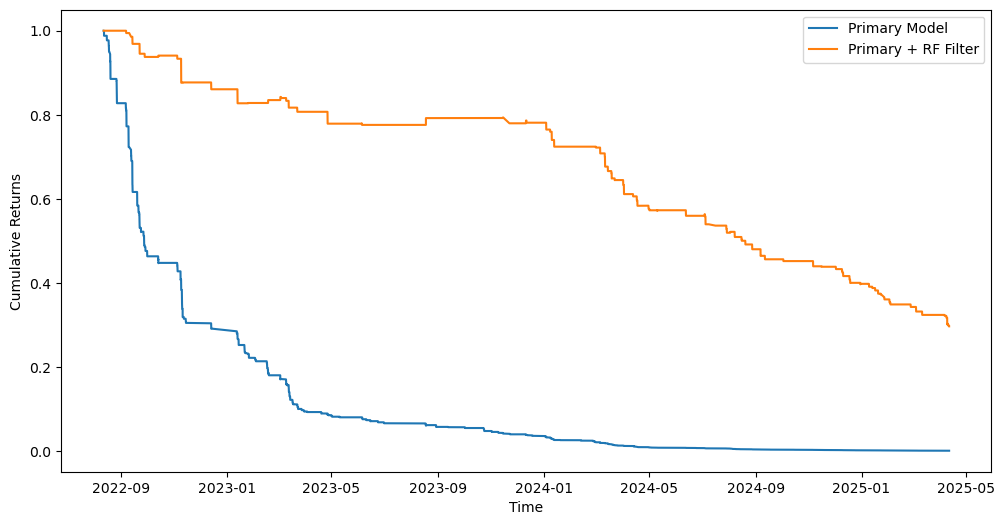

In [53]:
plt.figure(figsize=(12,6))
plt.plot(primary_cumret, label='Primary Model')
plt.plot(secondary_cumret, label='Primary + RF Filter')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


As we said this strategy on BTC was expecting to be a disaster... but the application of Meta-Labelling show how we "manage to reduce the losses"

## Connection to File SAMPLING WEIGHTS.IPYNB -- LAST EXERCISE

In [19]:
#save to CSV the train and test sets

train_df = X_train.copy()
train_df['y'] = y_train
train_df.to_csv('train.csv', index=True)

test_df = X_test.copy()
test_df['y'] = y_test
test_df.to_csv('test.csv', index=True)

